# Модуль 16. Метрики классификации несбалансированных данных

## Вводная часть

Поздравляем! Вы завершаете модуль «Несбалансированные данные» курса Machine Learning Engineer уровня Junior! В этом материале вы разберёте особенности использования различных метрик классификации при работе с несбалансированными данными.
Они дадут представление о преимуществах и недостатках различных метрик, а также помогут закрепить навыки работы с данными такого типа. 



## Почему качество классификации несбалансированных данных трудно оценить 

Несбалансированные данные могут влиять на определение оценки производительности моделей классификации. Модель может казаться достаточно точной при предсказании меток мажорного класса (например, accuracy), но она в целом будет плохо работать. Это означает, что к выбору метрики стоит подходить очень внимательно.

Рассмотрим проблему в работе модели на примере задачи классификации датасета, таргет которого содержит 10 000 отрицательных и 100 положительных меток:


In [ ]:
import numpy as np
import pandas as pd
np.random.seed(1)

# Сгенерируем истинные метки таргета
y = np.hstack((np.zeros((10000,)), np.ones((100,))))
np.random.shuffle(y)

# Выведем на экран первые 10 меток таргета
print(y[:10])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Представим, что вы обучили модель классификации, которая для таргета выдаёт следующие оценки вероятности позитивного класса:


In [ ]:
# Сгенерируем оценки вероятности позитивного класса
y_proba = np.random.uniform(0.1,0.51,10100)

# На их основе определим предсказанные метки классов
y_pred = np.where(y_proba > 0.5, 1, 0)

#Добавим истинные метки классов, оценки вероятности и предсказанные метки классов в один датасет
df = pd.DataFrame(data=np.array((y, y_proba, y_pred)).T, columns=['y_true', 'y_proba', 'y_pred'])
df.head()

,y_true,y_proba,y_pred
0,0.0,0.210127,0.0
1,0.0,0.338580,0.0
2,0.0,0.170399,0.0
3,1.0,0.494552,0.0
4,0.0,0.323127,0.0


Посмотрим на confusion_matrix и на её основе рассчитаем основные метрики классификации, оценим качество предсказаний:

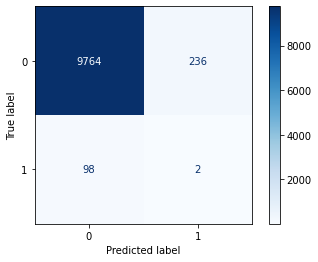

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f'Accuracy score: {accuracy_score(y, y_pred)}')
print(f'Precison: {precision_score(y, y_pred)}')
print(f'Recall: {recall_score(y, y_pred)}')

Accuracy score: 0.9669306930693069
Precison: 0.008403361344537815
Recall: 0.02


Accuracy модели имеет достаточно высокое значение — 0.97, потому что большая часть точек данных негативного класса была классифицирована правильно. Однако, обратите внимание на нижнюю строчку матрицы: из 100 точек данных позитивного класса только две были классифицированы корректно! Иными словами, recall нашей модели — всего 0.02. Более того, precision модели также очень низок: из 238 точек данных, которые были предсказаны как позитивный класс, только две представляют позитивный класс. 

Таким образом, в случае сильно несбалансированных данных, accuracy является очень опасной и ошибочной метрикой. Если бы в примере вывод о модели был сделан только на основе accuracy, была бы одобрена плохо работающая модель. Precision и recall, напротив, дают достаточно полную характеристику, от этого точность модели в классификации объектов минорного класса намного выше. Поскольку в несбалансированных данных минорный класс обычно имеет большую важность, чем мажорный, ошибки в классификации минорного класса являются более критичными.

## За какими метриками нужно следить во время обучения модели

В предыдущем разделе вы увидели, что precision и recall дают достаточное представление о качестве модели. Сложность использования этих метрик в том, что мониторить и сравнивать обе часто неудобно. Поэтому давайте рассмотрим ещё две распространённые метрики классификации: $F_1$-score и ROC AUC. Посчитаем их для предсказания нашей модели:

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

print(f'ROC AUC score: {roc_auc_score(y, y_proba)}')
print(f'F1-score: {f1_score(y, y_pred)}')

ROC AUC score: 0.45053
F1-score: 0.011834319526627219


Получился неожиданный ROC AUC — меньше 0.5. Это говорит о том, что в процессе обучения могли возникнуть ошибки или проблемы. Тем не менее величина этой метрики, близкая к 0.5, свидетельствует о том, что классификатор испытывает трудности в разделении позитивных и негативных точек данных и упускает из вида более общую картину: мажорный и минорный классы не равнозначны и минорный класс представляет большую ценность. 
С другой стороны, $F_1$-score, являясь средним гармоническим между precision и recall, совмещая в себе эти две метрики, хорошо показывает производительность модели в более важном для нас классе. 


## Как выбрать метрику, если одни ошибки критичнее других


У $F_1$-score есть свои недостатки. Часто в задачах, связанных с несбалансированными данными, не только классы, но и различные ошибки классификации (False Positive и False Negative) имеют разную ценность. Например, при обнаружении мошеннических платежей ошибки False Negative обычно важнее ошибок False Positive — последствия одобренного мошенничества страшнее, чем отклонённый добросовестный платёж. Иными словами, recall в этом случае важнее, чем precision. При этом нельзя фокусироваться только на recall, в противном случае модель будет помечать все платежи как мошеннические и получит recall, равный 1.

Напротив, если нужно предсказать необходимость химиотерапии, то последствия ошибки False Positive очень опасны, ведь химиотерапия, назначенная здоровому пациенту, сильно ему навредит. В этом случае precision важнее, чем recall.

Как видите, критичность ошибок зависит от решаемой задачи. Обычный 
𝐹1-score не делает различий между False Positive и False Negative, поэтому нужно использовать другие метрики, если ошибки могут быть разными по важности.

Эти метрики можно вывести из более общей метрики $F_{\beta}$-score, которая определяется по следующей формуле:

$$
F_{\beta} = (1 + {\beta}^2) \cdot \frac{P \cdot R}{{\beta}^2\cdot P + R},
$$

где P - precision, R - recall модели. Если в эту формулу вместо $\beta$ подставить 1, то получится формула $F_1$-score (поэтому эта метрика так и называется). В $F_1$-score precision и recall (а, следовательно, ошибки false positive и false negative) имеют равную важность. 

Однако можно варьировать $\beta$:
* Если задать $\beta > 1$, то в этом случае __recall важнее, чем precision__. В этой ситуации часто используют значение $\beta = 2$, которое дает метрику __$F_2$-score__
* Напротив, если нужно подчеркнуть, что __precision важнее, чем recall__, используют ${\beta} < 0$. Обычно используют значение $\beta = \frac{1}{2}$, которое дает метрику __$F_{\frac{1}{2}}$-score__.

Рассчитаем эти метрики для предсказаний нашей модели:


In [ ]:
from sklearn.metrics import fbeta_score


print(f'F2-score: {fbeta_score(y, y_pred, beta=2)}')
print(f'F(1/2)-score: {fbeta_score(y, y_pred, beta=0.5)}')

F2-score: 0.01567398119122257
F(1/2)-score: 0.009505703422053232


Как видите, метрики $F_1$-, $F_2$- и $F_{\frac{1}{2}}$-score имеют разные значения. Выбор одной из них для мониторинга и сравнения моделей напрямую зависит от задачи и цены той или иной ошибки.

## Выводы

В этом материале вы рассмотрели поведение основных метрик классификации на примере несбалансированных данных и сделали следующие выводы:
- Accuracy часто даёт неверные (завышенные) предсказания о качестве модели при несбалансированных данных.
- Precision и recall являются достаточно хорошими метриками, если минорный класс важнее.
- ROC AUC не учитывает, что минорный класс обычно важнее, чем мажорный.
- $F_1$-score яявляется хорошей метрикой, если ошибки False Positive и False Negative одинаково критичны.
- $F_2$-score и $F_{\frac{1}{2}}$-score позволяют сместить фокус на ошибки False Negative и False Positive соответственно.

До встречи!